In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv("Sharktankpitchesdeals.csv")
test = pd.read_csv("intermediate_testset.csv")

# Introduction
This project analyzes Shark Tank data, in which each entry contains the idea pitched, and a binary label indicating whether or not a deal was made for that pitch. With this dataset, our goal was to develop a natural language processing model that predicts whether or not a given pitch will land a deal based on its product description.

## Data Cleaning / Pre-processing

Since our task was to predict deals based on description, we mainly prioritized cleaning the **Description** column and **Deal Status** column entries.

In [3]:
# Renames columns for easier reference when coding
train = train.rename(columns={'Season_Epi_code': 'ep', 'Pitched_Business_Identifier': 'Pitch', 'Pitched_Business_Desc': 'Desc'})

# Ensures the 'Deal_Status' column consists of integers, and not strings
train['Deal_Status'] = train['Deal_Status'].apply(int)

# Removes any non-text characters that may still be contained in the string
train['Desc'] = train['Desc'].apply(lambda x: x.encode("ascii", "ignore").decode())
train

,ep,Pitch,Desc,Deal_Status,Deal_Shark
0,826,Bridal Buddy,a functional slip worn under a wedding gown th...,1,KOL+LG
1,826,Laid Brand,hair-care products made with pheromones . Laid...,0,NaN
2,826,Rocketbook,a notebook that can scan contents to cloud ser...,0,NaN
3,826,Wine & Design,painting classes with wine served . Wine & Des...,1,KOL
4,824,Peoples Design,a mixing bowl with a built-in scoop . Peoples ...,1,LG
...,...,...,...,...,...
701,101,Ava the Elephant,"(Emmy the Elephant during show, trademarked a...",1,BC
702,101,College Foxes Packing Boxes,a packing and organizing service based on an a...,0,NaN
703,101,Ionic Ear,an implantable Bluetooth device requiring surg...,0,NaN
704,101,Mr. Tod's Pie Factory,a pie company,1,BC+DJ


Before diving straight into analysis, we wanted to see if there was any correlation or relationship between description and deal status, outside of the contents of the description itself. This included features like description length, number of unique words, etc.

In [4]:
features = train.copy()

# Retrieves the word count of each description
features['Desc_len'] = features['Desc'].apply(lambda x: len(x.split()))

# Retrieves the number of unique words of each description
features['nunique'] = features['Desc'].apply(lambda x: len(set(x.split())))

# We can filter out the top 100 common words like 'a', 'and', 'the', etc. and quantify the uniqueness of a 
# description based on the average frequency of words
freq = features[['Pitch','Desc']]
freq['Desc'] = freq['Desc'].apply(str.split)
freq = freq.explode('Desc')['Desc'].value_counts()

# List of important words filtered out from original description
features['diverse'] = features['Desc'].apply(lambda y: list(filter(lambda x: x not in freq[:100], y.split())))
out = features[['Pitch','diverse']].explode('diverse')

# Calculated 'freq' value from formula created above
out['freq'] = out['diverse'].apply(lambda x: freq[x])
out = pd.DataFrame(out.groupby('Pitch')['freq'].mean()).reset_index()
features = features.merge(out[['Pitch','freq']], how='outer', on='Pitch')
features

/var/folders/0s/5m0f8zn14rj4s30b53jsshkr0000gn/T/ipykernel_6244/3774513342.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq['Desc'] = freq['Desc'].apply(str.split)


,ep,Pitch,Desc,Deal_Status,Deal_Shark,Desc_len,nunique,diverse,freq
0,826,Bridal Buddy,a functional slip worn under a wedding gown th...,1,KOL+LG,58,44,"[functional, slip, worn, under, wedding, gown,...",4.151515
1,826,Laid Brand,hair-care products made with pheromones . Laid...,0,NaN,31,30,"[hair-care, pheromones, Laid, brand, pheromone...",3.400000
2,826,Rocketbook,a notebook that can scan contents to cloud ser...,0,NaN,71,47,"[notebook, scan, contents, cloud, services, vi...",3.228571
3,826,Wine & Design,painting classes with wine served . Wine & Des...,1,KOL,37,33,"[painting, classes, served, Wine, &, Design, s...",4.280000
4,824,Peoples Design,a mixing bowl with a built-in scoop . Peoples ...,1,LG,43,36,"[mixing, bowl, built-in, scoop, Peoples, Desig...",4.310345
...,...,...,...,...,...,...,...,...,...
701,101,Ava the Elephant,"(Emmy the Elephant during show, trademarked a...",1,BC,45,26,"[(Emmy, Elephant, during, show,, trademarked, ...",6.187500
702,101,College Foxes Packing Boxes,a packing and organizing service based on an a...,0,NaN,39,22,"[packing, organizing, based, already, successf...",3.280000
703,101,Ionic Ear,an implantable Bluetooth device requiring surg...,0,NaN,24,14,"[implantable, Bluetooth, requiring, surgery, i...",3.750000
704,101,Mr. Tod's Pie Factory,a pie company,1,BC+DJ,3,3,[pie],1.000000


# Visualizations

### Comparisons of Averages

**Description Length**

In [5]:
features.groupby('Deal_Status')['Desc_len'].apply(np.mean)

Deal_Status
0    26.120743
1    32.731070
Name: Desc_len, dtype: float64

**# of Unique Words**

In [6]:
features.groupby('Deal_Status')['nunique'].apply(np.mean)

Deal_Status
0    19.473684
1    25.404700
Name: nunique, dtype: float64

**Calculated 'Freq' Value**

In [7]:
features.groupby('Deal_Status')['freq'].apply(np.mean)

Deal_Status
0    4.803017
1    4.795254
Name: freq, dtype: float64

From the statistics above, it seems that our **freq value means are the same**, while the **description length** and **number of unique words** seem to **differ between groups slightly**. However, more exploration must be conducted before making any assumptions or drawing any conclusions.

### **Distributions of Pitch Word Counts** (Deal vs No Deal)

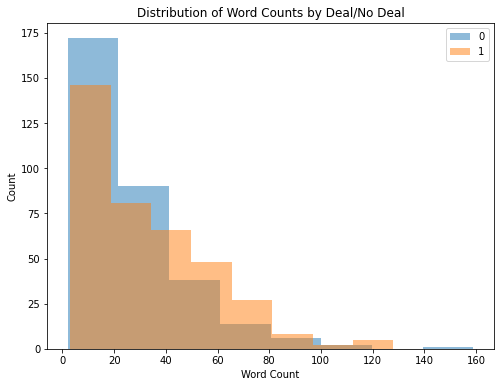

In [8]:
len_dist = features.groupby('Deal_Status')['Desc_len'].apply(list)
plt.figure(figsize=(8,6))
plt.hist(len_dist[0], bins=8, alpha=0.5, label='0')
plt.hist(len_dist[1], bins=8, alpha=0.5, label='1')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Distribution of Word Counts by Deal/No Deal')
plt.legend(loc='upper right')

From the visual above, despite differing in means earlier, we see that the overall distribution of word counts are **quite the same** whether a deal was made or not.

### **Distributions of Pitch Unique Word Counts** (Deal vs No Deal)

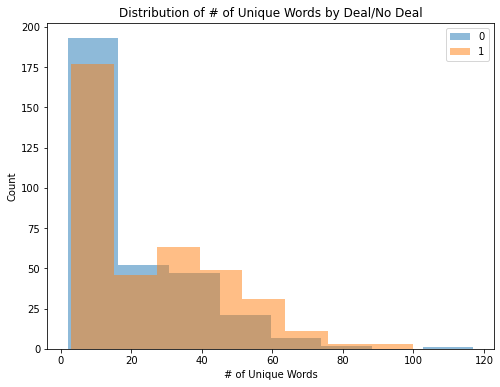

In [9]:
unique_dist = features.groupby('Deal_Status')['nunique'].apply(list)
plt.figure(figsize=(8,6))
plt.hist(unique_dist[0], bins=8, alpha=0.5, label='0')
plt.hist(unique_dist[1], bins=8, alpha=0.5, label='1')
plt.xlabel('# of Unique Words')
plt.ylabel('Count')
plt.title('Distribution of # of Unique Words by Deal/No Deal')
plt.legend(loc='upper right')

While the distributions for number of unique words seem similar, the distribution for pitches that landed deals seems to be **slightly bi-modal.** This may be useful in predicting, as the other frequencies before had solely an inverse relationship with our variables.

### **Distributions of Pitch Uniqueness** (Deal vs No Deal)

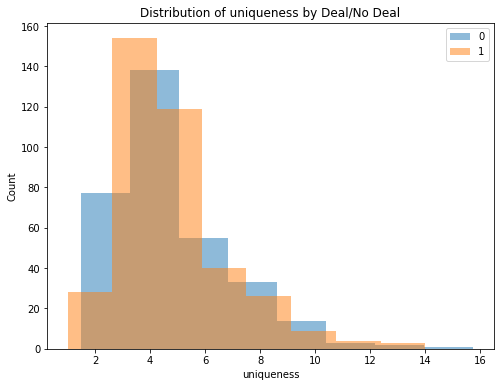

In [10]:
freq_dist = features.groupby('Deal_Status')['freq'].apply(list)
plt.figure(figsize=(8,6))
plt.hist(freq_dist[0], bins=8, alpha=0.5, label='0')
plt.hist(freq_dist[1], bins=8, alpha=0.5, label='1')
plt.xlabel('uniqueness')
plt.ylabel('Count')
plt.title('Distribution of uniqueness by Deal/No Deal')
plt.legend(loc='upper right')

as speculated from the descriptive statistics, the distribution of our freq values across classes is **incredibly similar,** and thus not helpful in discerning between deals or no deals.

After taking a deeper look into the distributions of our engineered features, it seems like the number of unique words may have some sort of influence on the decision of making a deal. Now, we will create a Natural Language Processing model, along with our quantification of unique words, to try and predict deals.

# Analysis / Results

### Avg Word2Vec & KNN

The first model we will try is a combination of **Word2Vec** and **K-Nearest Neighbors.** With this, each sentence will be converted into an array of numbers, with each number referencing the vector-numerical (size 200) representation of each word in the sentence. The new features will then be used to train a K-Nearest Neighbors model, and a **gridsearch** will be conducted to optimize the number of parameters and metric formula used to calculate the distances between the points.

In [11]:
sentences = list(train['Desc'].apply(str.split))

In [12]:
word2vec = Word2Vec(sentences=sentences, window=15, vector_size=200, min_count=2)

# Each sentence is represented by the average word vector value of all words in the sentence
def avgVec(data):
    out = []
    for each in data:
        count = 0
        vec = np.zeros(200)
        for every in each:
            if every in list(word2vec.wv.key_to_index.keys()):
                vec+=word2vec.wv.get_vector(every)
                count+=1
        if count!=0:
            vec/=count
            out.append(vec)
        if count == 0:
            out.append(vec)
    return out

In [13]:
trainVec = pd.DataFrame(avgVec(sentences))

In [14]:
knn = KNeighborsClassifier()
param = {'n_neighbors' : [5,10,15,20,30,40,50,60,100], 'metric' : ['manhattan', 'minkowski', 'euclidean', 'chebyshev']}
opt = GridSearchCV(knn, param)
opt.fit(trainVec, train['Deal_Status'])
print(opt.best_params_)
train['predict knn'] = opt.predict(trainVec)
print('Accuracy: ' + str((train['predict knn'] == train['Deal_Status']).mean()))
print('F1 Score: ' + str(f1_score(train['Deal_Status'], train['predict knn'])))

{'metric': 'minkowski', 'n_neighbors': 20}
Accuracy: 0.6005665722379604
F1 Score: 0.6289473684210526


Our GridSearch shows that the minkowski distance with 20-NN yields the highest accuracy at around **60%.** Our F1 score is about **0.63.** Let's see if we can create a better model.

### CountVectorizer, # of Unique Words, and Logistic Regression

The next model uses a combination of **CountVectorizer**, **number of unique words**, and **Logistic Regression**. CountVectorizer, similarly to Word2Vec, vectorizes each sentence based on its words' frequencies throughout the entire dataset. We added the number of unique words as another feature to see if it serves as an effective factor in determining deals. We presume that pitches with a higher number of unique words indicate that the owners of the pitch have extensive knowledge of their product, and they are able to articulate the effectiveness of their product well. Thus, the sharks might be more willing to secure a deal with pitches that seem to be more well-researched.

In [15]:
CountVec = CountVectorizer(ngram_range=(1,1), tokenizer = lambda x: x.split(), max_features=1500)
Count_data = CountVec.fit_transform(train['Desc'])
cv_dataframe = pd.DataFrame(Count_data.toarray(), columns=CountVec.get_feature_names())
cv_dataframe['nunique'] = train['Desc'].apply(lambda x: len(set(x.split())))
cv_dataframe

,&,.,10,100,100%,12,15,3,360,3d,...,you.,youll,young,your,youre,yourself,youve,zip-lock,zomm,nunique
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,44
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,47
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,33
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26
702,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
703,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,14
704,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [16]:
model = LogisticRegression()
model.fit(cv_dataframe, train['Deal_Status'])

/Users/hienbui/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
test_data = CountVec.transform(train['Desc'])
train_df = pd.DataFrame(test_data.toarray(), columns=CountVec.get_feature_names())
train_df['nunique'] = train['Desc'].apply(lambda x: len(set(x.split())))
train['predict logistic regression'] = model.predict(train_df)
print('Accuracy: ' + str((train['predict logistic regression'] == train['Deal_Status']).mean()))
print('F1 Score: ' + str(f1_score(train['Deal_Status'], train['predict logistic regression'])))

Accuracy: 0.9716713881019831
F1 Score: 0.9738903394255874


As shown above, this model yields an accuracy of about **97%** and an F1 score of **0.97**, which is much better than our first model.

### Predicting on Test data

In [18]:
test = test.rename(columns={'Season_Epi_code': 'ep', 'Pitched_Business_Identifier': 'Pitch', 'Pitched_Business_Desc': 'Desc'})
test['Desc'] = test['Desc'].apply(lambda x: x.encode("ascii", "ignore").decode())
test_out = CountVec.transform(test['Desc'])
test_df = pd.DataFrame(test_out.toarray(), columns=CountVec.get_feature_names())
test_df['nunique'] = test['Desc'].apply(lambda x: len(set(x.split())))
test['predict'] = model.predict(test_df)
test


,ep,Pitch,Desc,predict
0,410,Nearly Newlywed,"a bridal dress boutique which buys, sells, and...",0
1,104,Gift Card Rescue,a web site that buys and resells unused gift c...,1
2,415,The Green Garmento,an eco-friendly garment bag . an eco-friendly ...,0
3,823,Flag,a free photo printing service that prints ads ...,0
4,629,Budsies,a company that creates custom plush toys based...,0
...,...,...,...,...
171,814,DBest Products,a line of carriers and portable carts . dbest ...,1
172,108,Treasure Chest Pets,an organizer for children designed like a stuf...,1
173,504,ScreenMend,window screen repair patches . window screen r...,1
174,610,Heidi Ho,a dairy-free line of plant-based cheese spread...,1


In [19]:
test.rename(columns={'ep': 'Season_Epi_code', 
                     'Pitch': 'Pitched_Business_Identifier', 
                     'Desc': 'Pitched_Business_Desc'}
           ).to_csv('results.csv')

# Conclusion / Future Improvements

Based on the two models, we have concluded that the **second model,** consisting of CountVectorizer, # of unique words, and Logistic Regression yields a much better accuracy and F1 score. 

The second model yields a **97%** accuracy in comparison to **60%** from its counterpart. We assume that the improvement in the second model is due to the number of unique words, which has a greater influence on predicting the outcome of the pitch. 

The **number of unique words** serves as a better feature in comparison to simply the length of the description, because long descriptions could have many common, unimportant filler words. It also removes any fluff from pitches that use words repetitively during the presentation, which could indicate of lack of knowledge or research of the product from the ownder. Thus, the lack of unique words could deter sharks from offering deals while extensive vocabulary might persuade them. 

To further improve this model, we believe that a **larger dataset** and **more features** accessible to us will be more beneficial, such as the stake the pitchers ask for or whether a shark provides a counteroffer, which indicates that the shark approves of the pitch but requires more security to his/her investment. Naturally, with more data comes better models and predictions.